# **Setting up**

*   Download data files (words.zip & parser.txt) from Google Drive
*   Unzip words.zip
*   Install keras-tqdm & Levenshtein
*   Import neccessary packages

In [ ]:
!gdown --id 1idCx6pr1ptmHrEHjbbiQxF4xoCZ9dNtv
!gdown --id 1lZA6WjzssJQYBEN7XLq4rhtxuRpqqmhT

Downloading...
From: https://drive.google.com/uc?id=1idCx6pr1ptmHrEHjbbiQxF4xoCZ9dNtv
To: /content/words.zip
1.23GB [00:06, 197MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lZA6WjzssJQYBEN7XLq4rhtxuRpqqmhT
To: /content/parser.txt
5.30MB [00:00, 32.3MB/s]


In [ ]:
!unzip -q /content/words.zip -x "__MACOSX/*"

In [ ]:
pip install keras-tqdm

In [ ]:
pip install python-Levenshtein

     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149799 sha256=e15561b5d1a859a00e8bd8ad18d8ec496a5d13627127550703c57a0c85993bd1
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import Levenshtein as lv

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Preprocessing Data**
*   Open parser.txt and read contents to find filepaths (to be used later)
*   Read the image and convert into a gray-scale image
*   Make each image of size (128,32)
*   Expand image dimension as (128,32,1) to make it compatible with the input shape of architecture
*   Normalize the image pixel values by dividing it with 255
*   Read the text from the name of the image as the image name contains text written inside the image.
*   Encode each character of a word into some numerical value by creating a function( as ‘a’:0, ‘b’:1 …….. ‘z’:26 etc ). Let say we are having the word ‘abab’ then our encoded label would be [0,1,0,1]
*   Compute the maximum length from words and pad every output label to make it of the same size as the maximum length. This is done to make it compatible with the output shape of our RNN architecture
*   Take the first 10000 records and split into validation and training dataset as 10% and 90% respectively


In [ ]:
with open('/content/parser.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
def process_image(img):
    w, h = img.shape

    #aspect ratio calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    #convert each to (32, 128, 1)
    if (w < 32):
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if (h < 128):
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    else:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    
    #normalize 
    img = img / 255

    return img

In [ ]:
max_label_len = 0

chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ abcdefghijklmnopqrstuvwxyz1234567890-=!@#$%^&*()_+,\"./<>?;':[]\{}|`~"
print(chars, len(chars))

#encode each output word into digits
def label_encoder(txt):
    dig_list = []

    for index, char in enumerate(txt):
        dig_list.append(chars.index(char))

    return dig_list

ABCDEFGHIJKLMNOPQRSTUVWXYZ abcdefghijklmnopqrstuvwxyz1234567890-=!@#$%^&*()_+,"./<>?;':[]\{}|`~ 95


In [ ]:
images = []
labels = []

#lists for training dataset
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

#lists for validation dataset
valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

RECORDS_COUNT = 10000


for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0], splits_id[1], word_id)
        
        #process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        #process label
        try:
            label = label_encoder(word)
        except:
            continue
        
        #compute maximum length of the text
        if len(word) > max_label_len:
            max_label_len = len(word)
                                
        #split the 10000 data into validation and training dataset as 10% and 90% respectively
        if (index % 10) == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
    
    #break the loop if total data is more than 10000
    if index >= RECORDS_COUNT:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels, maxlen=max_label_len, padding='post', value=len(chars))
valid_padded_label = pad_sequences(valid_labels, maxlen=max_label_len, padding='post', value=len(chars))

train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [ ]:
#convert to np array
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

train_images.shape, valid_images.shape

((7850, 32, 128, 1), (876, 32, 128, 1))

# **Convolutional Recurrent Neural Network**
*   Input shape for the architecture has an input image of height 32 and width 128.
*   Use seven convolution layers of which 6 are have kernel size (3,3) and one is of size (2.2)
*   Increase number of filters from 64 to 512 layer by layer
*   Add two max-pooling layers of size (2,2) and then two max-pooling layers of size (2,1) are to extract features with a larger width (to predict long texts)
*   Use batch normalization layers after fifth and sixth convolution layers which accelerate the training process
*   Use a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer
*   Use two Bidirectional LSTM layers each of which has 256 units with droupout=0.5 and a dense layer with activation=softmax. This RNN layer gives the output of size (batch_size, 31, 96) where 96 is the total number of output classes including blank character

In [ ]:
#input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
#convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
#pooling layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

#pooling layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

#Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
#bidirectional LSTM layers with units=256 and dropout=0.5
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.5))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.5))(blstm_1)

#dense layer with activation=softmax 
outputs = Dense(len(chars)+1, activation = 'softmax')(blstm_2)

#model to be used for testing
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

# **CTC Loss Function**
*   Use the CTC loss function. CTC loss is very helpful in text recognition problems. It helps prevent annotating each time step and helps erradicate the problem where a single character can span multiple time step which needs further processing if we do not use CTC.
*   CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this,  need to create a custom loss function and then pass it to the model. To make it compatible with model, create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing.

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

# **Training the Model**
*   Train the model using SGD
*   Use Keras callbacks functionality to save the weights of the best model on the basis of validation loss
*  In model.compile(), it can be that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier. labels as input to the model earlier.
*   Train model on 7850 training images and 876 validation images
*   SGD is slow but a better optimizer overall and with a small batchsize, stable convergence is ensured

In [ ]:
batch_size = 2
epochs = 75
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="E{}-BS{}.hdf5".format(str(epochs), str(batch_size))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/75
3925/3925 [==============================] - 82s 18ms/step - loss: 16.4724 - accuracy: 4.3729e-04 - val_loss: 13.8009 - val_accuracy: 0.0445

Epoch 00001: val_loss improved from inf to 13.80091, saving model to E75-BS2.hdf5
Epoch 2/75
3925/3925 [==============================] - 69s 18ms/step - loss: 12.5692 - accuracy: 0.0268 - val_loss: 11.1154 - val_accuracy: 0.0719

Epoch 00002: val_loss improved from 13.80091 to 11.11543, saving model to E75-BS2.hdf5
Epoch 3/75
3925/3925 [==============================] - 69s 18ms/step - loss: 10.6105 - accuracy: 0.0684 - val_loss: 10.4656 - val_accuracy: 0.0674

Epoch 00003: val_loss improved from 11.11543 to 10.46562, saving model to E75-BS2.hdf5
Epoch 4/75
3925/3925 [==============================] - 69s 18ms/step - loss: 8.8493 - accuracy: 0.1010 - val_loss: 7.4625 - val_accuracy: 0.1724

Epoch 00004: val_loss improved from 10.46562 to 7.46249, saving model to E75-BS2.hdf5
Epoch 5/75
3925/3925 [==============================] - 69s 

# **Training Accuracy**
*   As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Use the CTC decoder to get the output text.
*   Plot accuracy and loss against epoch for training and validation sets

original_text =   Labour
predicted text = Labour

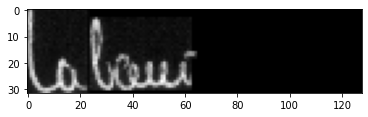



original_text =   0MPs
predicted text = 0MPs

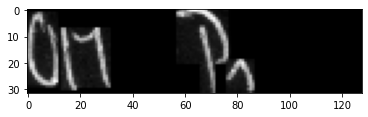



original_text =   tomorrow
predicted text = tomorrow

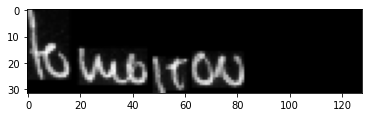



original_text =   .
predicted text = .

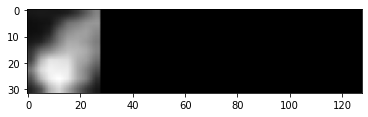



original_text =   Mr.
predicted text = Mr.

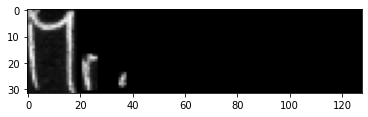



original_text =   Michael
predicted text = Michael

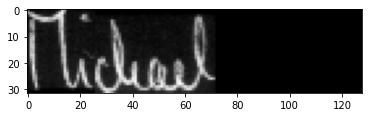



original_text =   Foot
predicted text = Foot

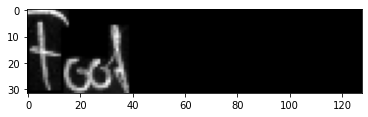



original_text =   put
predicted text = put

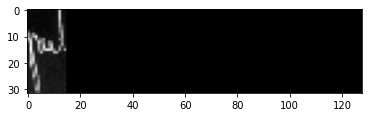



original_text =   down
predicted text = down

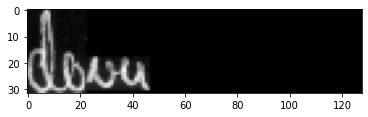



original_text =   a
predicted text = a

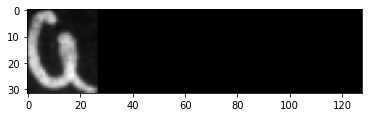



original_text =   resolution
predicted text = resolution

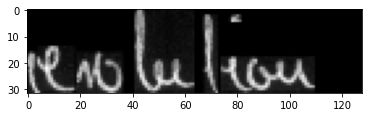



original_text =   on
predicted text = on

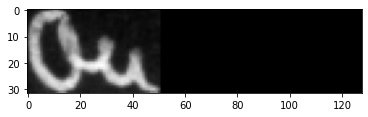



original_text =   the
predicted text = the

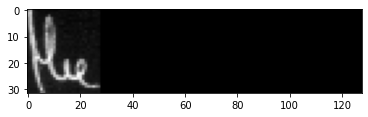



original_text =   subject
predicted text = subject

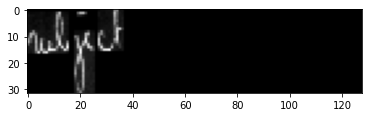



original_text =   and
predicted text = and

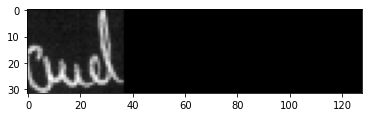



original_text =   he
predicted text = he

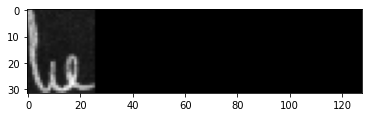



original_text =   to
predicted text = to

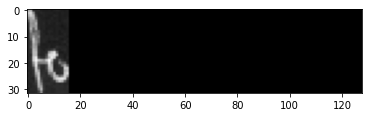



original_text =   be
predicted text = be

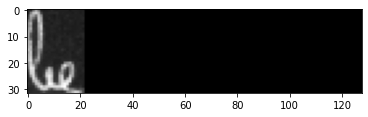



original_text =   backed
predicted text = backed

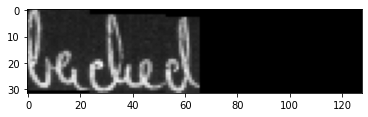



original_text =   by
predicted text = by

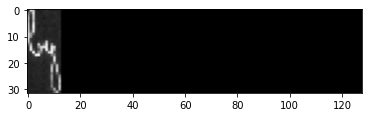



original_text =   Mr.
predicted text = Mr.

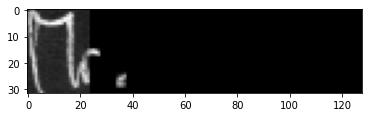



original_text =   Will
predicted text = Will

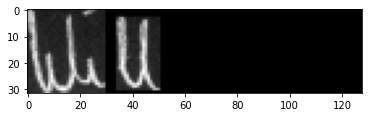



original_text =   Griffiths
predicted text = Griffiths

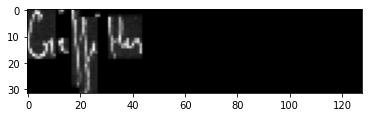



original_text =   ,
predicted text = ,

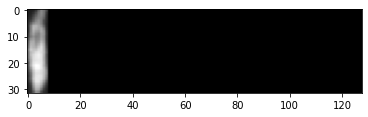



original_text =   0MP
predicted text = 0MP

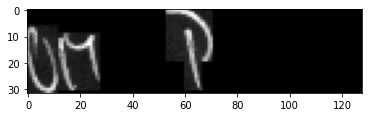

In [ ]:
#predict outputs on validation images
prediction = act_model.predict(train_images[50:75])
 
#use CTC decoder
decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
out = K.get_value(decoded)

for i, x in enumerate(out):
    print("original_text =  ", train_original_text[50+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(chars[int(p)], end = '')
    plt.imshow(train_images[50+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

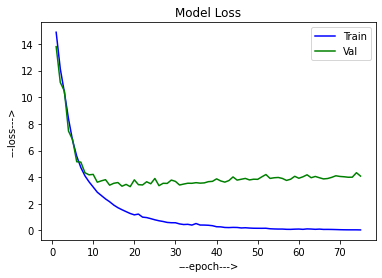

In [ ]:
def plotgraph(epochs, X, Y):
    plt.plot(epochs, X, 'b')
    plt.plot(epochs, Y, 'g')
    if (flag==0):
      plt.title('Model Loss')
      plt.ylabel('---loss--->')
      plt.legend(['Train', 'Val'], loc='upper right')
    else:
      plt.title('Model Accuracy')
      plt.ylabel('---accuracy--->')
      plt.legend(['Train', 'Val'], loc='upper left')
    plt.xlabel('---epoch--->')
    plt.show()

flag=0
plotgraph(epochs, loss, val_loss)

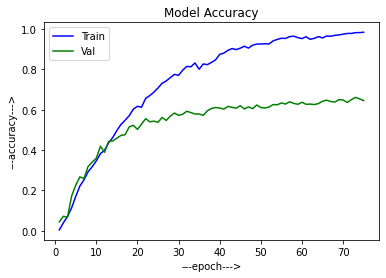

In [ ]:
flag=1
plotgraph(epochs, acc, val_acc)

# **Testing Accuracy**

In [ ]:
#load the weights saved for the best model
act_model.load_weights(filepath)

#predict outputs on validation images
prediction = act_model.predict(valid_images)
 
#CTC decoder
decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
out = K.get_value(decoded)

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=chars[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.9052370928369793
ratio: 0.8721430826519967


# **Best Model**
*   Output best model info to history.txt

In [ ]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
with open('history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)